In [11]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models
from matplotlib.patches import Rectangle
import csv

In [51]:
data_root = ".\\dataset"
print(os.listdir(data_root))

['test', 'train', 'train_data.csv']


In [52]:
train_dir = "train"
val_dir = "val"
class_names = ["d0_no", "d1_human"]

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, train_dir, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        img = cv2.imread(os.path.join(source_dir, file_name), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        cv2.imwrite(os.path.join(dest_dir, file_name), img)

100%|██████████| 3/3 [00:00<00:00, 68.58it/s]


In [53]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [54]:
xc = []
yc = []
w = []
h = []

with open(os.path.join(data_root, "train_data.csv"), 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        xc.append(float(row[1]))
        yc.append(float(row[2]))
        w.append(float(row[3]))
        h.append(float(row[4]))

In [55]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        if original_tuple[1] == 0:
            tuple_new = (original_tuple + (-1, -1, -1, -1,))
        elif original_tuple[1] == 1:
            id = int(path.split("\\")[2].replace(".jpg", ""))
            tuple_new = (original_tuple + (xc[id], yc[id], w[id], h[id],))
        return tuple_new

In [56]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = ImageFolderWithPaths(train_dir, train_transforms)
val_dataset = ImageFolderWithPaths(val_dir, val_transforms)

print(train_dataset.samples)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

[('train\\d0_no\\1.jpg', 0), ('train\\d0_no\\2.jpg', 0), ('train\\d1_human\\1.jpg', 1), ('train\\d1_human\\2.jpg', 1)]


In [57]:
len(train_dataloader), len(train_dataset)

(1, 4)

In [58]:
def show_input(input_tensor, title='', num_batch=0, num_elem_batch=0):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    image = image.clip(0, 1)
    plt.imshow(image)
    rect = Rectangle((50, 50), 150, 150, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.title(str(num_batch) + "." + str(num_elem_batch) + ") " + title)
    plt.show()
    plt.pause(0.001)

def show_input_all(dataloader):
    it = iter(dataloader)
    for i in range(len(dataloader)):
        X_batch, y_batch, xc_batch, yc_batch, w_batch, h_batch = next(it)
        print("y_batch:", y_batch)
        print("xc_batch:", xc_batch)
        print("yc_batch:", yc_batch)
        print("w_batch:", w_batch)
        print("h_batch:", h_batch)
        num_elem_batch = 0
        for x_item, y_item in zip(X_batch, y_batch):
            show_input(x_item, title=class_names[y_item], num_batch=i+1, num_elem_batch=num_elem_batch+1)
            num_elem_batch += 1

y_batch: tensor([0, 1, 1, 0])
xc_batch: tensor([-1.0000,  0.9000,  0.4000, -1.0000])
yc_batch: tensor([-1.0000,  0.2000,  0.8000, -1.0000])
w_batch: tensor([-1.,  1., 12., -1.])
h_batch: tensor([-1.,  3., 15., -1.])


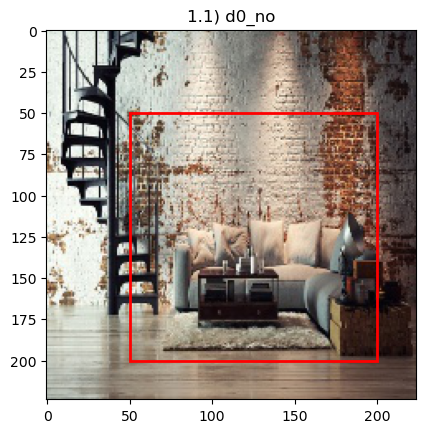

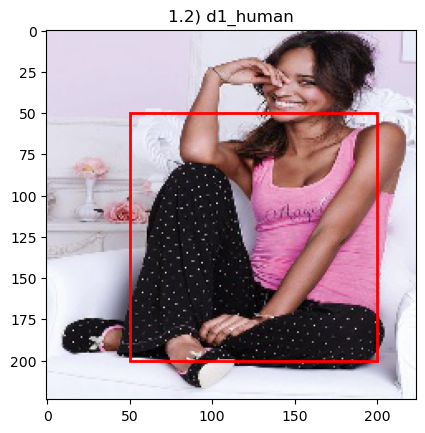

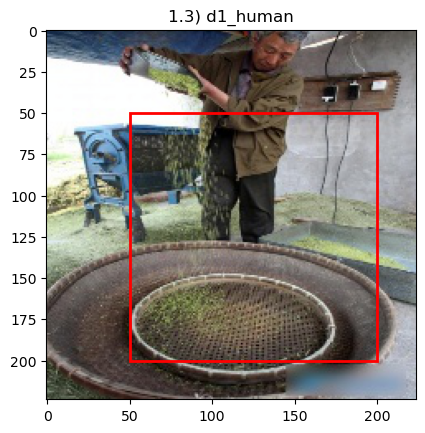

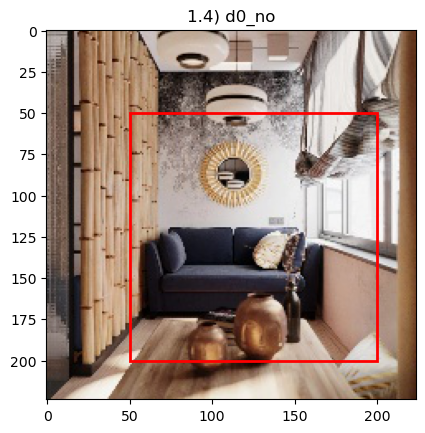

In [59]:
show_input_all(train_dataloader)

y_batch: tensor([0, 1])
xc_batch: tensor([-1.0000,  0.3000])
yc_batch: tensor([-1.0000,  0.6000])
w_batch: tensor([-1.,  7.])
h_batch: tensor([-1., 19.])


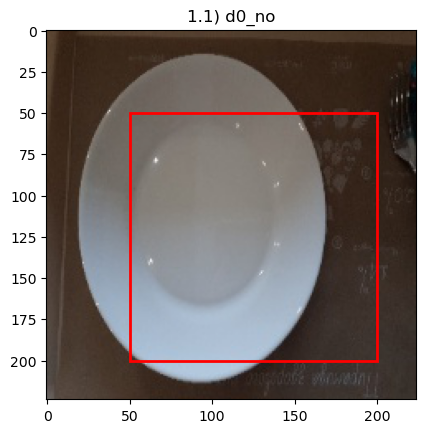

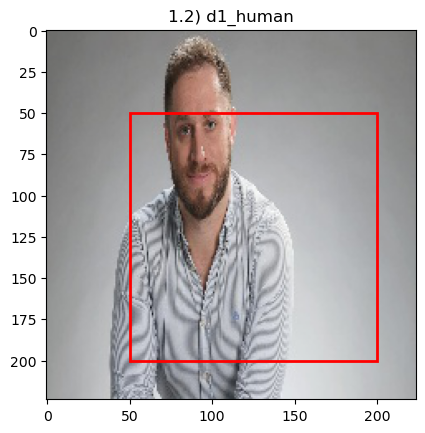

In [60]:
show_input_all(val_dataloader)

In [ ]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

def train_model(model, sigmoid_act, bce_loss, mse_loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels, xcs, ycs, ws, hs in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                xcs = xcs.to(device)
                ycs = ycs.to(device)
                ws = ws.to(device)
                hs = hs.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    
                    loss_value = bce_loss(sigmoid_act(preds[:, 0:1]), labels) +
                                        labels * (bce_loss(sigmoid_act(preds[:, 1:2]), xcs) + bce_loss(sigmoid_act(preds[:, 2:3]), ycs) +
                                                                            mse_loss(preds[:, 3:4], torch.log(ws)) +
                                                                            mse_loss(preds[:, 4:5], torch.log(hs)))
                    
                    # preds_class = preds.argmax(dim=1)
                    preds_class = [1 if pred.item() > 0.5 else 0 for pred in preds[:, 0:1]]
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)

    return model

In [ ]:
model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 5)

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

sigmoid_act = torch.nn.Sigmoid()

bce_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(model, sigmoid_act, bce_loss, mse_loss, optimizer, scheduler, num_epochs=30)

In [ ]:
losses = {}
accuracies = {}

losses['train'], accuracies['train'] = train_loss_history, [elem.item() for elem in train_accuracy_history]
losses['val'], accuracies['val'] = val_loss_history, [elem.item() for elem in val_accuracy_history]

In [ ]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Loss')
print(losses['train'])
print(losses['val'])

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Accuracy')
print(accuracies['train'])
print(accuracies['val'])

In [10]:
# !rm -rf train val test